In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1차 생성된 DB를 재로딩해서 추가적인 insight 반영


Task1. 일차 생성된 pur_10000.csv 데이터셋을 통계적 탐색 방법을 통하여 특성을 파악한 후 추가적인 인사이트를 적절하게 반영하세요.

#### Reasonable한 데이터셋 구축을 위한 DB 변경 방향
  - 난수 발생을 통한 대동 소이한 남/여에 따른 구매력은 현실에 맞지 않아 인터넷 의류 쇼핑몰이란 가정에 맞게 남성 대비 여성의 구매력 증가 시킴
  - 남/여에 따라 선호하는 상품 금액대가 다를 것이고 과제에서는 남성의 경우 저가 상품 및 고가 상품의 비율이 낮고 상대적으로 중가 제품 선택 빈도 높음, 여성이 상대적으로 고가품을 구매하는 경향을 반영 <br>
  - 연령대에 따른 구매력 차이 현실 반영: 10대/60대이상 구매력을 낮추고, 30대, 20대, 40대 순으로 수정<br>
  - 연령대에 따라 선호하는 상품 금액대 조정 <br>
  (10대 저가 상품 선호, 40대 이상 고가품 선호로 수정) <br>
  - 위와 같은 성별,연령대 반영으로 주 고객층을 20대 후반에서 30대 중반의 여성으로 조정
  - 현실은 지역별로 인구가 상이해서 고객층이 상이. 이를 반영하기 위해 특정 도시라 가정하고 도시 규모/인구에 구매력 조정
  - 상품 가격대 분포 조정 각 인터넷 판매 싸이트마다 히트 상품이 있을 것이고 이러한 상품들에 판매 실적의 peak가 있을 것이므로 ==> Multi-Peaks Gaussian Distribution 적용 <br>
  - 위와 같은 price 조정과 더블어 판매 개수에 있어서도 1~100개까지 주문하는건 현실과는 동떨어짐. ~5 이하 개수 주문이 주류일 것이므로 이를 반영하기 위해 log-normal distribution을 반영하여 최종 상품 구매액 분포 조정 <br>
  - 2020년 vs. 2021년 매출 조정 (코로나 팬데믹으로 인해 20년 중반기 이후 인터넷 주문량 급증 반영)<br>
  - 여름철 대비 겨울철에 의류 가격이 상대적으로 고가인 제품 주문량이 증가 반영 <br>
  - 시간 구간별 매출을 PrimeTime (18시-12시) >> DayTime (7시-18시): 점심시간에 주문 slightly peak 반영 > DayBreak (12시-7시) 순으로 수정 반영 <br>
  - 추가적으로 구매 수량의 경우 log-normal distribution으로 data를 어느정도 현실을 반영했지만, 여전히 box plot으로보면 많은 data가 이상치로 들어가 있어 이를 수정

In [ ]:
import numpy as np
import pandas as pd
file_path = '/content/drive/MyDrive/KITA_2024/M3_분석라이브러리/Statistics/data_gen.csv'
df = pd.read_csv(file_path)

In [ ]:
data = df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   OrderID         10000 non-null  int64 
 1   CustID          10000 non-null  int64 
 2   ProdID          10000 non-null  int64 
 3   Quantity        10000 non-null  int64 
 4   Gender          10000 non-null  int64 
 5   Age             10000 non-null  int64 
 6   Region          10000 non-null  int64 
 7   Price           10000 non-null  int64 
 8   OrderAmount     10000 non-null  int64 
 9   AgeGroup        10000 non-null  object
 10  PriceCategory   10000 non-null  object
 11  OrderDate       10000 non-null  object
 12  OrderDW         10000 non-null  object
 13  OrderTime       10000 non-null  object
 14  Year            10000 non-null  int64 
 15  Season          10000 non-null  object
 16  OrderTimeGroup  10000 non-null  object
dtypes: int64(10), object(7)
memory usage: 1.3+ MB


In [ ]:
# 결측치 확인
data.isnull().sum().sum()

0

### 가격, 구매 수량, 총 구매 금액 분포를 정규분포에 근사
- 1차 data 생성 시 이미 가격과 구매 수량에 이미 가우시안 분포를 적용 완료 <br>
  (구매 수량의 경우 Log(x)가 가우시안 분포를 그리도록 설정: Log-normal Distribution)
- 가격대의 경우 저가, 중가, 고가 물품 가테고리 중 인기 품목이 있을 것이고 이는 multi-peak distribution을 가질 것이라 판단하고 ~5000, ~30000, ~40000에서 peak를 갖는 distribution을 구현 완료 <br>

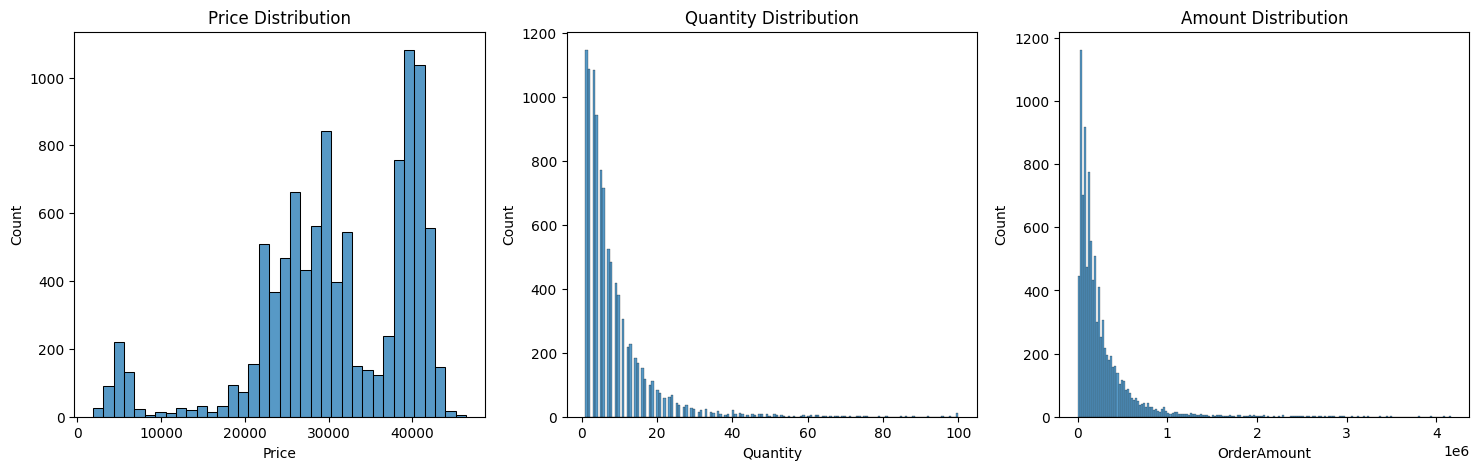

In [ ]:
# 가격, 구매 수량, 총 구매 금액 분포 시각화
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data['Price'], ax=axes[0])
axes[0].set_title('Price Distribution')

sns.histplot(data['Quantity'], ax=axes[1])
axes[1].set_title('Quantity Distribution')

sns.histplot(data['OrderAmount'], ax=axes[2])
axes[2].set_title('Amount Distribution')

plt.show()

#### 남/여 고객비 & 연령대별 고객 분포
- 인터넷 의류 쇼핑몰이라 가정하고 실습을 진행 ==> 남성에 비해 여성 고객이 주류
- 고객 연령대도 중장년층보다는 30대 아래 고객층이 주류를 이루도록 조정 (주 고객층을 20대 후반에서 30대 중반의 여성으로)

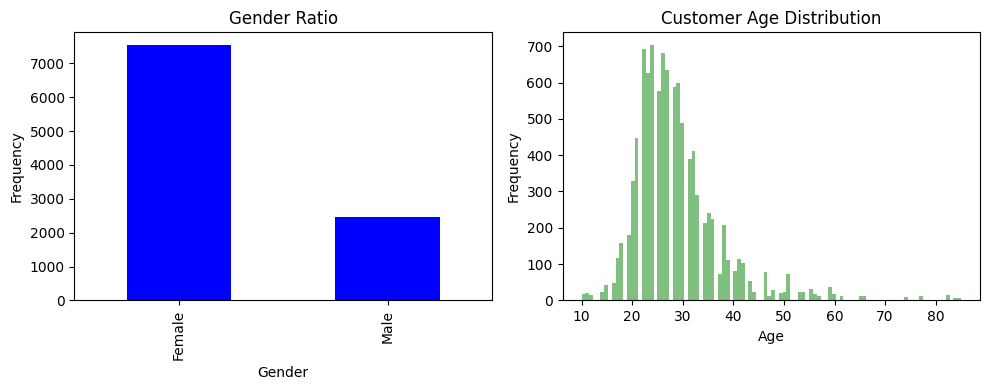

In [ ]:
############## 남/녀 고객 구성비, 고객 연령대 분포
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax=data.groupby(['Gender']).size().plot(kind='bar', color='b')
ax.set_xticklabels(['Female', 'Male'])
plt.title('Gender Ratio')
plt.xlabel("Gender")
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
data['Age'].plot.hist(alpha=0.5, bins=100, color='g')
plt.title('Customer Age Distribution')
plt.xlabel("Age")
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 연령대별 선호 상품 가격대
- 일반적으로 중장년층은 경제적으로 여유로워 고가품 위주로 구매
- 의류에는 일반적으로 남성보다는 여성이 고가 제품을 많이 사는 구매 특성을 반영

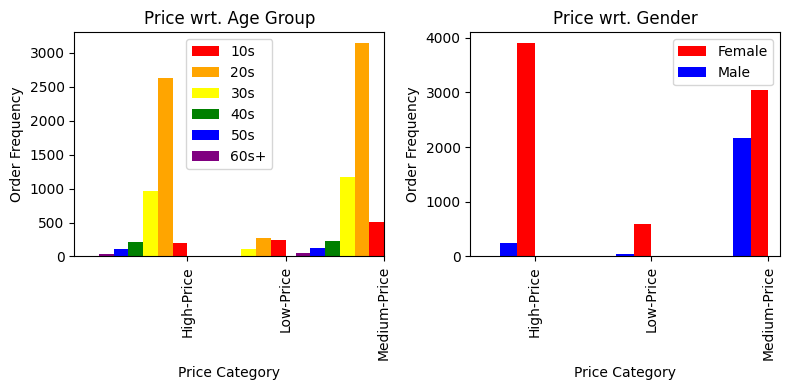

In [ ]:
# 연령대에 따른 선호 상품 가격대 비교
# 구매 상품의 가격대 분류

# Plot 비교
AgeLabels = ['10s', '20s', '30s', '40s', '50s', '60s+']
PriceDistrib_Age = data.groupby(['AgeGroup', 'PriceCategory']).size()
PriceDistrib_Age = PriceDistrib_Age.unstack()

GenderList = [0, 1]
GenderLabels = ['Female', 'Male']
PriceDistrib_Gender = data.groupby(['Gender', 'PriceCategory']).size()
PriceDistrib_Gender = PriceDistrib_Gender.unstack()

# Plot 비교
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
for i, age_group in enumerate(AgeLabels):
    PriceDistrib_Age.loc[age_group].plot(kind='bar', color=colors[i], width=0.15, position=i+1, label=age_group)
plt.title('Price wrt. Age Group')
plt.xlabel('Price Category')
plt.ylabel('Order Frequency')
plt.legend()

plt.subplot(1, 2, 2)
colors = ['red', 'blue']
for i, Gender in enumerate(GenderList):
    PriceDistrib_Gender.loc[Gender].plot(kind='bar', color=colors[i], width=0.15, position=i+1, label=GenderLabels[i])
plt.title('Price wrt. Gender')
plt.xlabel('Price Category')
plt.ylabel('Order Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## 2020, 2021년 년도별 매출, 시간대별 매출
- 코로나 팬데믹으로 인해 20년 중반기 이후 인터넷 주문량 급증 반영<br>
- 새벽시간, 근무시간대에는 구매가 적고 저녁 시간에 활발한 구매가 이뤄짐을 반영하여 시간 구간별 매출을 'PrimeTime' >> 'DayTime' > 'DayBreak' 순으로 반영 <br>

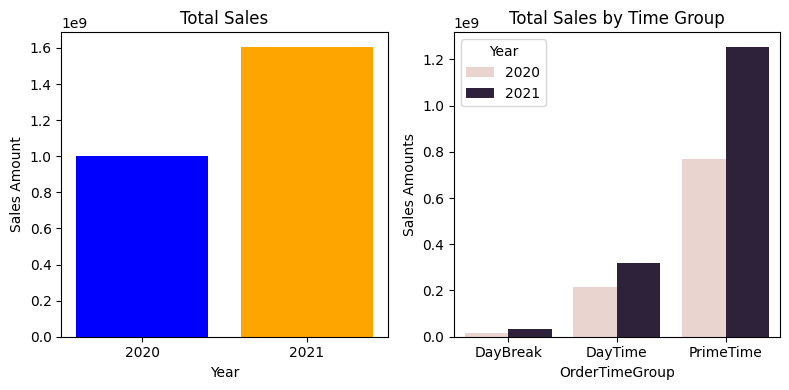

In [ ]:
# 2020년과 2021년의 주문 데이터 분리
orders_2020 = data[data['Year'] == 2020]
orders_2021 = data[data['Year'] == 2021]

# 2020년과 2021년 각각의 총 매출액 계산
total_sales_2020 = orders_2020['OrderAmount'].sum()
total_sales_2021 = orders_2021['OrderAmount'].sum()


# 시간대별 총 매출 건수와 총 매출액 계산
grouped_orders_2020 = orders_2020.groupby(['OrderTimeGroup', 'Year']).apply(lambda x: pd.Series({
    'OrderCount': x['OrderID'].nunique(),
    'TotalSales': x['OrderAmount'].sum(),
})).reset_index()

grouped_orders_2021 = orders_2021.groupby(['OrderTimeGroup', 'Year']).apply(lambda x: pd.Series({
    'OrderCount': x['OrderID'].nunique(),
    'TotalSales': x['OrderAmount'].sum(),
})).reset_index()


# 시각화
years = ['2020', '2021']
total_sales = [total_sales_2020, total_sales_2021]

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.bar(years, total_sales, color=['blue', 'orange'])
plt.title('Total Sales')
plt.ylabel('Sales Amount')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
sns.barplot(x='OrderTimeGroup', y='TotalSales', hue='Year', data=pd.concat([grouped_orders_2020, grouped_orders_2021]))
plt.title('Total Sales by Time Group')
plt.ylabel('Sales Amounts')
plt.tight_layout()
plt.show()

## 계절별 매출 분포
- 여름철 대비 겨울철에 의류 가격이 상대적으로 고가인 제품 주문량이 증가 반영 <br>

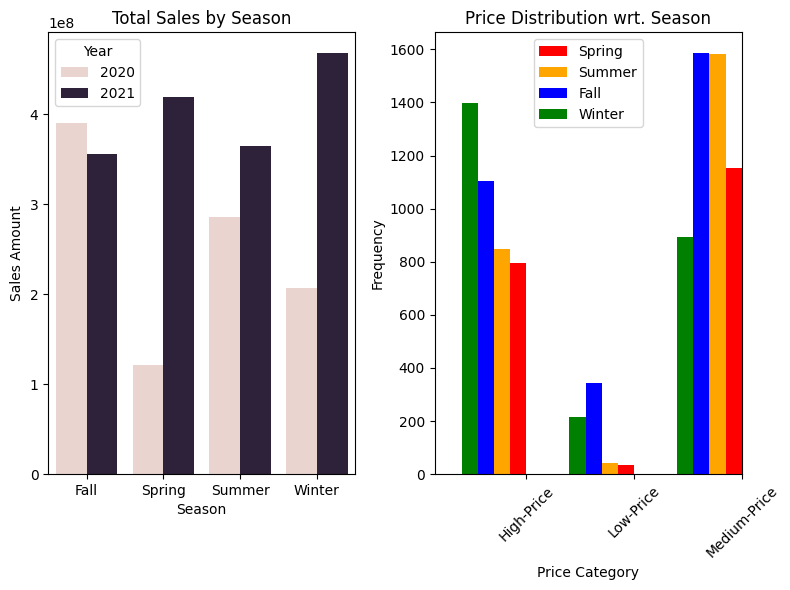

In [ ]:
grouped_orders_2020_season = orders_2020.groupby(['Season', 'Year']).agg({'OrderID': 'nunique', 'OrderAmount': 'sum'}).reset_index()
grouped_orders_2021_season = orders_2021.groupby(['Season', 'Year']).agg({'OrderID': 'nunique', 'OrderAmount': 'sum'}).reset_index()

# 계절에 따른 선호 상품 가격대 비교
SeasonLabels = ['Spring', 'Summer', 'Fall', 'Winter']
PriceDistrib_Season = data.groupby(['Season', 'PriceCategory']).size()
PriceDistrib_Season = PriceDistrib_Season.unstack()

# 시각화
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Season', y='OrderAmount', hue='Year', data=pd.concat([grouped_orders_2020_season, grouped_orders_2021_season]))
plt.title('Total Sales by Season')
plt.ylabel('Sales Amount')

plt.subplot(1, 2, 2)
colors = ['red', 'orange', 'blue', 'green']
for i, Season in enumerate(SeasonLabels):
    PriceDistrib_Season.loc[Season].plot(kind='bar', color=colors[i], width=0.15, position=i+1, label=Season)
plt.title('Price Distribution wrt. Season')
plt.xlabel('Price Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 구매 고객의 지역 분포
- 인구 밀집 지역인 서울/경기권 도시들에 고객층이 두터울 것을 모사하여 고객 지역 분포 설정

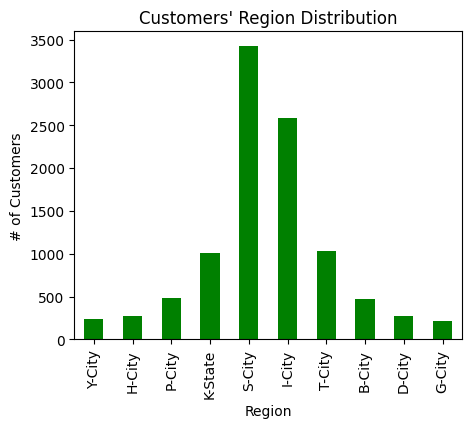

In [ ]:
# 구매 고객 지역 분포 시각화
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
labels = ['Y-City', 'H-City', 'P-City','K-State', 'S-City', 'I-City', 'T-City', 'B-City', 'D-City','G-City']
data['RegionName'] = pd.cut(data['Region'], bins=bins, labels=labels)

plt.figure(figsize=(5,4))
data.groupby(['RegionName']).size().plot(kind='bar', color='g')
plt.title("Customers' Region Distribution")
plt.xlabel("Region")
plt.ylabel('# of Customers')
plt.show()


## 구매 수량 이상치 제거
구매 수량 액의 분포에 이상치가 포함되어 있는데, 이를 현실에 맞게 수정

In [ ]:
data['Quantity'].unique()

array([  3,  48,  17,  25,   1,   7,  41,  14,   6,  27,   5,  10,   4,
         9,  11,   2,  15,  19,  13,  23,   8,  22,  36,  12,  16,  33,
        32,  53,  18,  35,  24,  21,  40,  20,  34,  43,  39,  31,  51,
        29,  88,  49,  59,  46,  30,  28,  37,  44,  26,  76,  45,  38,
        73,  42,  62,  71,  60, 100,  47,  74,  55,  54,  70,  65,  96,
        66,  68,  63,  81,  69,  86,  52,  58,  85,  50,  61,  92,  98,
        64,  67,  56,  75,  79])

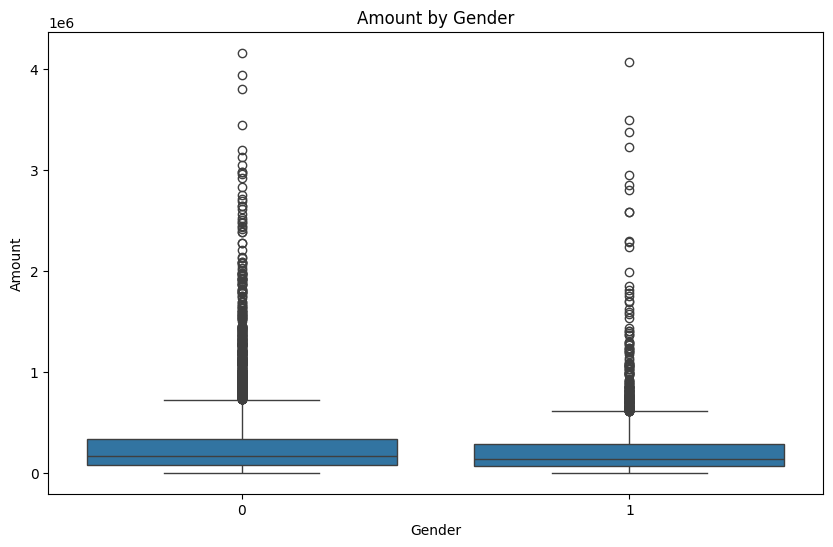

In [ ]:
# 성별에 따른 총 구매 금액의 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='OrderAmount', data=data)
plt.title('Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Amount')
plt.show()

In [1]:
## 구매수량 조정
## 이전 data에서는 1~100까지 난수로 구매수량이 정의 되었는데, 10개 이상의 구매 수량은 현실적이지 않음
## 1차로 구매 수량 10개 이상을 최소화 시키기 위해서 log-normal distribution을 적용하여 1차 data가공을 했지만 위의 plot에서와 같이
## 여전히 이상치가 포함되어 있으므로 구매 수량이 11이상인 data를 찾고 해당하는 value는 1~10까지의 난수로 재지정
## 구매 수량이 11 이상인 위치에 1~10까지의 난수 발생
## 가격의 경우 1000~50000까지 분포하게 해놓았기 때문에 Reasonable한 범위라고 판단하여 그대로 둠
data['Quantity'] = data['Quantity'].apply(lambda x: np.random.randint(1, 11) if x > 10 else x)
data['OrderAmount'] = data['Price'] * data['Quantity']

NameError: name 'data' is not defined

In [ ]:
# 성별에 따른 총 구매 금액의 분포 시각화
plt.figure(figsize=(9, 10))
plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='Quantity', data=data)
plt.title('Order-Quantities by Gender')
plt.xlabel('Gender')
plt.ylabel('Quantitie')

plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='OrderAmount', data=data)
plt.title('Order-Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Quantitie')


plt.show()

In [ ]:
data.isnull().sum().sum()

0

In [ ]:
import os
os.chdir('/content/drive/MyDrive/KITA_2024/M3_분석라이브러리/Statistics/')
data.to_csv('data_rev.csv', index=None)